In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from ucimlrepo import fetch_ucirepo 

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from data_transform import linear_transform

In [3]:
# fetch dataset 
poker_hand = fetch_ucirepo(id=158) 
  
# data (as pandas dataframes) 
X = poker_hand.data.features 
y = poker_hand.data.targets 
  
# metadata 
print(poker_hand.metadata) 
  
# variable information 
print(poker_hand.variables)

# Define class names for evaluation report
class_names = {
    0: "Nothing in hand",
    1: "One pair",
    2: "Two pairs",
    3: "Three of a kind",
    4: "Straight",
    5: "Flush",
    6: "Full house",
    7: "Four of a kind",
    8: "Straight flush",
    9: "Royal flush"
}


{'uci_id': 158, 'name': 'Poker Hand', 'repository_url': 'https://archive.ics.uci.edu/dataset/158/poker+hand', 'data_url': 'https://archive.ics.uci.edu/static/public/158/data.csv', 'abstract': 'Purpose is to predict poker hands', 'area': 'Games', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1025010, 'num_features': 10, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['CLASS'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2002, 'last_updated': 'Sat Mar 09 2024', 'dataset_doi': '10.24432/C5KW38', 'creators': ['Robert Cattral', 'Franz Oppacher'], 'intro_paper': None, 'additional_info': {'summary': 'Each record is an example of a hand consisting of five playing cards drawn from a standard deck of 52. Each card is described using two attributes (suit and rank), for a total of 10 predictive attributes. There is one Class attribute that describes the "Poker Hand". T

### Prétraitement des données

---

- **Séparation en training, validation et test** : on sépare la donnée entre le jeu d'entraînement, de validation et d'évaluation finale

- **Normalisation** : Cruciale pour mettre toutes les caractéristiques sur une échelle commune. On utilisera pour cela la classe `StandardScaler` de sklearn

- **Distribution des classes** : Il est nécessaire que les classes soient identiquement distribuées afin que le modèle dispose de suffisament de données d'entraînement pour chaque classe

In [4]:
# split between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split between train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Transformation linéaire de la donnée 
---

On essaye ici d'appliquer la transformation linéaire discutée dans l'article [Poker Hand Dataset- A Machine Learning Analysis and a Practical Linear Transformation](#file:Poker%20Hand%20Dataset-%20A%20Machine%20Learning%20Analysis%20and%20a%20Practical%20Linear%20Transformation%20.pdf-context)

Cette transformation vise à réduire la dépendance à l'ordre des cartes : 
- les attributs de 1 à 13 représentent le nombre de cartes de chaque rang, de l'As (1) au Roi (13)
- les attributs de 14 à 17 représentent le nombre de cartes de chaque couleur (14 : Coeur, 15 : Pique, 16 : Carreau, 17 : Trèfle)
- Le 18ème attribut est inchangé, il s'agit de la classification de la main et c'est l'output qu'on cherche à prédire




In [32]:
transformed_data = linear_transform(X)

### Réseau de neurones 

---

Dans cette partie on utilisera un MLP (multi-layer perceptron) pour classifier les données. On commencera arbitrairement par un MLP à 3 couches (1 output et 2 hidden layers), la couche d'entrée aura 10 neurones car il y a 10 features, celle de sortie aura aussi 10 neurones car il y a 10 classes possibles. Les couches cachées auront chacune 10 neurones.


<p style="color:red; text-align:center;">L'entraînement du MLP dans les conditions suivantes peut prendre <u><b>environ 3 minutes</b></u>.</p>


In [4]:

# Define the MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), activation="relu", solver='adam', random_state=42)

# Train the model
mlp.fit(X_train_scaled, y_train.values.ravel())


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(10, 10), random_state=42)

### Évaluation du modèle

Classification Report:
                 precision    recall  f1-score   support

Nothing in hand       0.71      0.83      0.77     82510
       One pair       0.66      0.62      0.64     69121
      Two pairs       0.31      0.03      0.06      7799
Three of a kind       0.43      0.12      0.19      3338
       Straight       0.00      0.00      0.00       620
          Flush       1.00      0.00      0.00       342
     Full house       0.25      0.00      0.01       235
 Four of a kind       1.00      0.18      0.30        34
 Straight flush       1.00      0.00      0.00         1
    Royal flush       1.00      0.00      0.00         2

       accuracy                           0.69    164002
      macro avg       0.64      0.18      0.20    164002
   weighted avg       0.66      0.69      0.66    164002



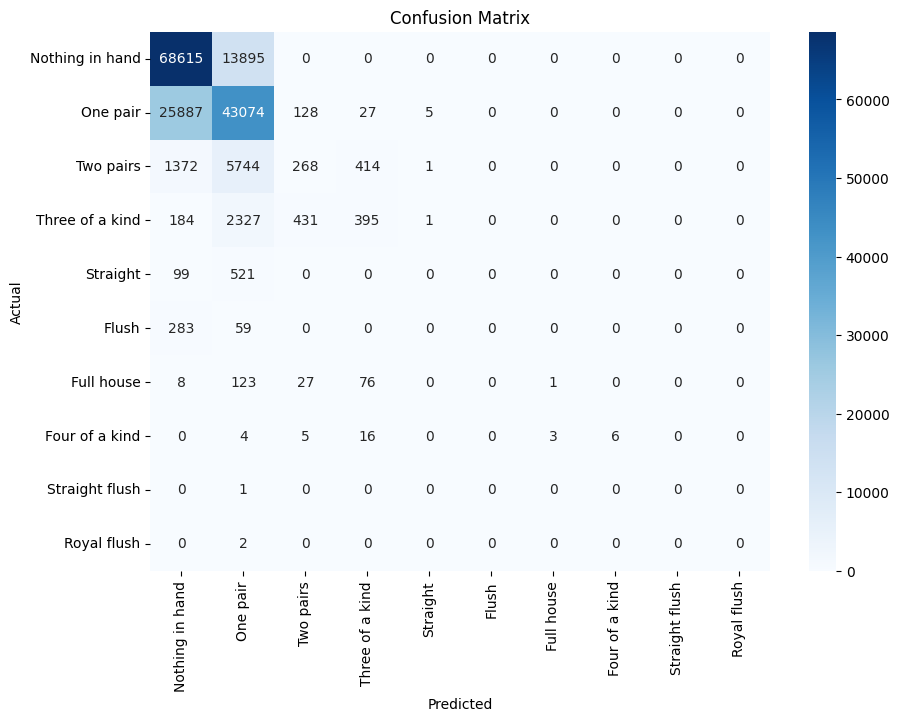

In [5]:
# Predict on the test set
y_test_pred = mlp.predict(X_val_scaled)

# Generate classification report
report = classification_report(y_val, y_test_pred, target_names=list(class_names.values()), zero_division=1)
print(f'Classification Report:\n{report}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Remarques
Notre premier modèle semble peu robuste. En effet, on obtient un `f1-score=0.2` (en macro, donc sans avantager les classes dominantes).


### Fine-tuning des hyperparamètres

Essayons de modifier les hyperparamètres de notre réseau de neurones à l'aide d'une recherche de type `GridSearch`. Nous allons en particulier nous intéresser aux paramètres suivants :

- taille du réseau (topologie)
- régularisation L2 (paramètre `alpha`)
- taux d'apprentissage (paramètre `learning_rate`)

Par ailleurs nous utiliserons la cross-validation (3 folds) pour éviter l'overfitting


<p style="color:red; text-align:center;">L'exécution de cette cellule peut prendre <u><b>environ une heure</b></u>.</p>


In [6]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100), (10, 10), (100, 100), (100,100,100)],
    'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001,0.001, 0.01, 0.1]
}

# Initialize the MLPClassifier
mlp = MLPClassifier(activation="relu", solver='adam', max_iter=100, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_scaled, y_train.values.ravel())

# Print the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Fitting 3 folds for each of 80 candidates, totalling 240 fits


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.6min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.6min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 1.8min
[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 1.8min
[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 1.8min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 1.8min
[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 1.8min
[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  12.1s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 1.8min
[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  12.5s
[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  16.3s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min
[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.2min
[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  59.6s
[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.2s
[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.3s
[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   8.7s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.7min
[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  41.1s
[CV] END alpha=1e-06, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time= 1.0min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 1.0min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 1.7min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 1.9min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 1.2min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  26.4s
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 2.1min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  30.9s
[CV] END alpha=1e-06, hidden_layer_sizes

/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.1min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.2min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 2.0min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time=  52.5s
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 2.5min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.6min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  42.4s
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.2min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  51.4s
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  45.6s
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; to

/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.0min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.0min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 6.0min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 6.1min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.1min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.1min
[CV] END alpha=1e-06, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 6.0min
[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  13.5s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.1min
[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  19.3s
[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  31.4s
[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.6min
[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.6min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.0min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.8min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min
[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.7s
[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=  11.0s
[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.8s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.2min
[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  41.2s
[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  48.8s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.3min
[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time= 1.1min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.3min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 1.6min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 2.1min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 2.4min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 2.0min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  28.4s
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  28.1s
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  27.2s
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 3.0min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 1.6min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.5min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.5min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.5min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.3min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 1.5min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.5min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  37.2s
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 2.9min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 3.5min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time= 1.0min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  47.4s
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; to

/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.0min
[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 5.8min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.0min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.0min
[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  12.6s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=1e-05, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 6.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.0min
[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  14.2s
[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  18.5s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.2min
[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.0min
[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.5min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 1.9min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min
[CV] END alpha=0.0001, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.8min
[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.9s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min
[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=  10.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  41.9s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.2min
[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.2min
[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  59.2s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time= 1.2min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time=  49.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time=  49.6s
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  31.9s
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 2.0min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 1.9min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 2.4min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  24.9s
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 1.1min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  25.2s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 3.9min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 3.9min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.0min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 1.9min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 2.2min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time=  49.6s
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.4min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  49.3s
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.5min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  59.7s
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  51.2s
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init

/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.1min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.2min
[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 5.8min
[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  13.8s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.3min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 6.3min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 6.2min
[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  16.1s
[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  14.2s
[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.4min
[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.6min
[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.4min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.3min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.3min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.3min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.3min
[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.0s
[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.7s
[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.7s
[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  27.9s
[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  38.8s
[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.3min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.3min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time= 1.4min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 1.8min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 3.3min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 3.3min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 2.5min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  31.5s
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  33.3s
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  30.3s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.5min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.5min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.5min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 4.1min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 2.4min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.5min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.7min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 2.4min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.6min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time= 1.1min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time= 1.2min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  

/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.5min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.5min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 6.0min
[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 6.9min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.0001; total time= 2.4min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 7.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 7.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.3min
[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  19.6s
[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  14.8s
[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.1; total time=  19.3s
[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.4min
[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.4min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.01; total time= 1.9min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.1min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=100, learning_rate_init=0.001; total time= 2.1min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.3min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.3min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.0001; total time= 1.2min
[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.8s
[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.7s
[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.1; total time=   9.3s
[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  46.7s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.3min
[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  59.3s
[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.01; total time=  52.6s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.2min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(10, 10), learning_rate_init=0.001; total time= 1.2min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 1.4min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 1.5min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  25.0s
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time= 1.2min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 3.6min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.01; total time= 2.0min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.4min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.4min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.1; total time=  56.2s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.0001; total time= 4.5min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 4.5min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.001; total time= 4.5min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.4min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 2.0min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  42.0s
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01; total time= 1.3min
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  46.8s
[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.1; total time=  54.7s


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 5.5min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 6.1min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 6.1min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.0001; total time= 5.9min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 5.8min


/Users/clovispiedallu/Desktop/DAML_project/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001; total time= 6.1min
Best parameters found: {'alpha': 1e-06, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate_init': 0.001}
Best cross-validation score: 0.9302377772706886


### Choix du modèle 

Le modèle présentant les meilleures performances est obtenu avec les hyperparamètres suivants : 

- `hidden_layer_sizes`: (100,100,100)
- `alpha`: 0.0000001
- `learning_rate_init`: 0.001 (correspond à `learning_rate` car le choix est de le prendre constant)

On va maintenant entraîner le modèle avec ces paramètres :

In [1]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_test_pred_best = best_model.predict(X_test_scaled)

# Generate classification report for the best model
report_best = classification_report(y_test, y_test_pred_best, target_names=list(class_names.values()), zero_division=1)
print(f'Classification Report for Best Model:\n{report_best}')

# Generate confusion matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_test_pred_best)

# Plot confusion matrix for the best model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best Model')
plt.show()


NameError: name 'grid_search' is not defined

In [5]:

# Define the MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                    learning_rate_init=0.001,
                    alpha=1e-6,
                    activation="relu",
                    solver='adam', 
                    random_state=42, 
                    max_iter=100
                    )

# Train the model
mlp.fit(X_train_scaled, y_train.values.ravel())


MLPClassifier(alpha=1e-06, hidden_layer_sizes=(100, 100, 100), random_state=42)

### Évaluation du modèle fine-tuné sur le dataset de validation

Classification Report Best Model:
                 precision    recall  f1-score   support

Nothing in hand       1.00      1.00      1.00     82510
       One pair       1.00      1.00      1.00     69121
      Two pairs       1.00      1.00      1.00      7799
Three of a kind       1.00      1.00      1.00      3338
       Straight       0.95      1.00      0.97       620
          Flush       1.00      1.00      1.00       342
     Full house       1.00      1.00      1.00       235
 Four of a kind       1.00      1.00      1.00        34
 Straight flush       0.50      1.00      0.67         1
    Royal flush       1.00      0.00      0.00         2

       accuracy                           1.00    164002
      macro avg       0.94      0.90      0.86    164002
   weighted avg       1.00      1.00      1.00    164002



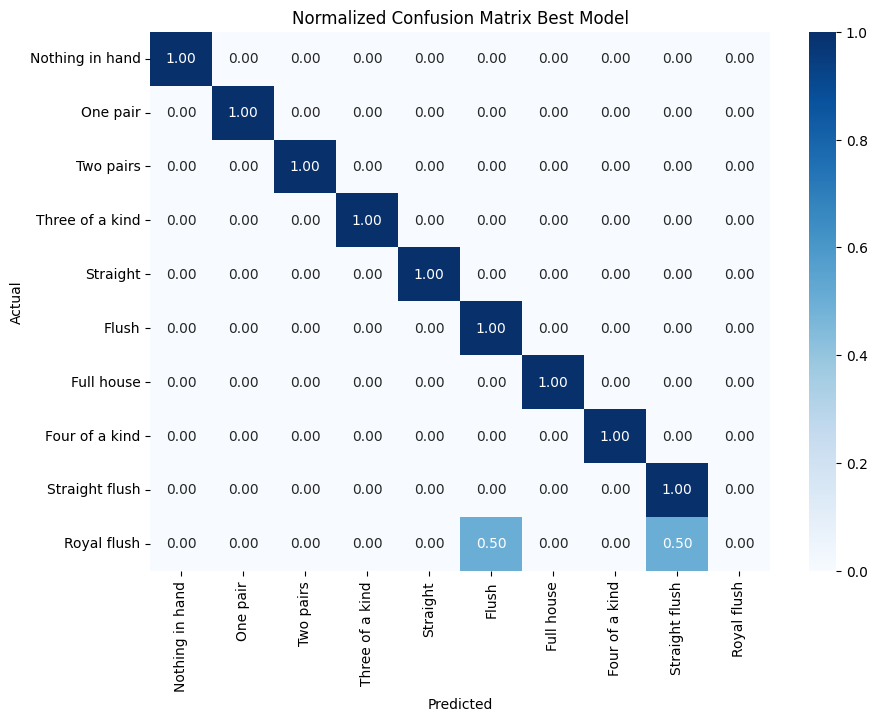

In [11]:
# Predict on the test set
y_val_pred = mlp.predict(X_val_scaled)

# Generate classification report
report = classification_report(y_val, y_val_pred, target_names=list(class_names.values()), zero_division=1)
print(f'Classification Report Best Model:\n{report}')

# Generate normalized confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred, 
                               normalize='true'
                               )

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix Best Model')
plt.show()


### Remarque sur les premiers résultats
---

Notre modèle peu robuste pour classifier les mains rares comme la royale flush, notamment car la donnée est semble inégalement distribuée. En effet on observe :


In [12]:
# Calcul de la proportion des classes 0 et 1 dans le dataset complet
class_counts = y['CLASS'].value_counts(normalize=True)
poids_classe_0 = class_counts[0] * 100
poids_classe_1 = class_counts[1] * 100
poids_reste = 100 - poids_classe_0 - poids_classe_1

print(f"Poids de la classe 'Nothing in hand': {poids_classe_0:.2f}%")
print(f"Poids de la classe 'One pair': {poids_classe_1:.2f}%")
print(f"Poids du reste: {poids_reste:.2f}%")

Poids de la classe 'Nothing in hand': 50.12%
Poids de la classe 'One pair': 42.25%
Poids du reste: 7.63%


Pour contourner ce problème, essayons de rajouter artificiellement des données de classes sous-représentées dans les données d'entraînement

Essayons désormais d'appliquer la transformation linéaire suggérée dans l'article associé. Elle vise à réduire la dépendance du modèle à l'ordre des cartes et fait plutôt apparaître les données caractéristiques d'une main de valeur (nombre de carte de la même couleur, cartes de valeur successives)

---